### Data Collection : Source - Kaggle 
#### Context
All companies in the SEC EDGAR database. Companies are listed with company name and their unique CIK key. Data-set had 663000 companies listed, which includes all companies in the EDGAR database.

#### Import libraries

In [73]:
import pandas as pd
import numpy as np
from scipy.sparse import csr_matrix
import sparse_dot_topn.sparse_dot_topn as ct
import matplotlib.pyplot as plt
import re
from sklearn.feature_extraction.text import TfidfVectorizer
import time

In [2]:
df = pd.read_csv("data/sec__edgar_company_info.csv")

In [3]:
print(df.shape)
df.head()

(663000, 3)


,Line Number,Company Name,Company CIK Key
0,1,!J INC,1438823
1,2,"#1 A LIFESAFER HOLDINGS, INC.",1509607
2,3,#1 ARIZONA DISCOUNT PROPERTIES LLC,1457512
3,4,#1 PAINTBALL CORP,1433777
4,5,$ LLC,1427189


The data has a lot special characters and starting with numbers. Let's perform some cleaning

In [59]:
def cleannames(string):
    string = string.lower()
    string = string.replace('&', 'and')
    string = string.replace(',', ' ')
    string = string.replace('-', ' ')
    string = re.sub('\W+',' ', string ) # removing special characters
    string = re.sub('\d+',' ', string ) # removing numbers preceding the company names
    string = string.title()
    return string

In [60]:
# storing the cleaned names under 'Cleaned Company Name'
df['Cleaned Company Name'] = df['Company Name'].apply(cleannames)
df.head()

,Line Number,Company Name,Company CIK Key,Cleaned Company Name
0,1,!J INC,1438823,J Inc
1,2,"#1 A LIFESAFER HOLDINGS, INC.",1509607,A Lifesafer Holdings Inc
2,3,#1 ARIZONA DISCOUNT PROPERTIES LLC,1457512,Arizona Discount Properties Llc
3,4,#1 PAINTBALL CORP,1433777,Paintball Corp
4,5,$ LLC,1427189,Llc


In [48]:
# checking aggregates
df_aggregate = pd.DataFrame(df['Cleaned Company Name'].value_counts())
df_aggregate.head()

,Cleaned Company Name
ft,6586
advisors disciplined trust,1790
guggenheim defined portfolios series,936
van kampen unit trusts series,878
van kampen unit trusts municipal series,674


(array([6.17514e+05, 3.00000e+00, 1.00000e+00, 0.00000e+00, 0.00000e+00,
        0.00000e+00, 0.00000e+00, 0.00000e+00, 0.00000e+00, 1.00000e+00]),
 array([1.0000e+00, 6.5950e+02, 1.3180e+03, 1.9765e+03, 2.6350e+03,
        3.2935e+03, 3.9520e+03, 4.6105e+03, 5.2690e+03, 5.9275e+03,
        6.5860e+03]),
 <BarContainer object of 10 artists>)

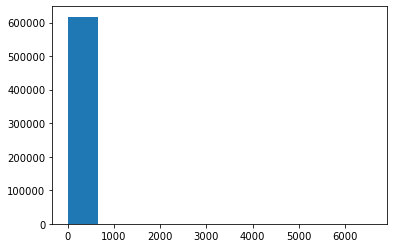

In [49]:
plt.hist(x = df_aggregate['Cleaned Company Name'], bins = 10)

## TF-IDF

TF-IDF is a statistical measure that evaluates how relevant a word is to a document in a collection of documents. This is done by multiplying two metrics: how many times a word appears in a document, and the inverse document frequency of the word across a set of documents.

- The term frequency of a word in a document. There are several ways of calculating this frequency, with the simplest being a raw count of instances a word appears in a document. Then, there are ways to adjust the frequency, by length of a document, or by the raw frequency of the most frequent word in a document.

- The inverse document frequency of the word across a set of documents. This means, how common or rare a word is in the entire document set. The closer it is to 0, the more common a word is. This metric can be calculated by taking the total number of documents, dividing it by the number of documents that contain a word, and calculating the logarithm.

- So, if the word is very common and appears in many documents, this number will approach 0. Otherwise, it will approach 1.

- TF-IDF is very useful in text classification and text clustering. It is used to transform documents into numeric vectors, that can easily be compared.

## N-gram

While the terms in TF-IDF are usually words, this is not a necessity. In our case using words as terms wouldn’t help us much, as most company names only contain one or two words. This is why we will use n-grams: sequences of N contiguous items, in this case characters.


In [50]:
def ngrams(string, n =3):
    #string = string.lower()
    #string = string.replace('&', 'and')
    #string = string.replace(',', ' ')
    #string = string.replace('-', ' ')
    string = re.sub('\W+','', string )
    ngrams = zip(*[string[i:] for i in range(n)])
    return[''.join(ngram) for ngram in ngrams]

In [51]:
ngrams('A LIFESAFER HOLDINGS, INC.', 3)

['ALI',
 'LIF',
 'IFE',
 'FES',
 'ESA',
 'SAF',
 'AFE',
 'FER',
 'ERH',
 'RHO',
 'HOL',
 'OLD',
 'LDI',
 'DIN',
 'ING',
 'NGS',
 'GSI',
 'SIN',
 'INC']

In [52]:
company_names = df['Cleaned Company Name']
Vectorizer = TfidfVectorizer(min_df = 1, analyzer = ngrams, use_idf=True)
tf_idf_matrix = Vectorizer.fit_transform(company_names)

In [55]:
print(tf_idf_matrix.shape)
print(tf_idf_matrix[0])
print(ngrams('j inc'))

(663000, 15767)
  (0, 5394)	0.29733831507509334
  (0, 5907)	0.9547721855962837
['jin', 'inc']


In [17]:
company_names

0                                      J Inc
1                  A Lifesafer Holdings Inc 
2            Arizona Discount Properties Llc
3                             Paintball Corp
4                                        Llc
                         ...                
662995                         Zz Global Llc
662996                 Zzif   Investment Llc
662997       Zzll Information Technology Inc
662998                               Zzx Llc
662999                 Zzyzx Zzazx Zzozx Inc
Name: Cleaned Company Name, Length: 663000, dtype: object

## Cosine Similarity

Cosine similarity measures the similarity between two vectors of an inner product space. It is measured by the cosine of the angle between two vectors and determines whether two vectors are pointing in roughly the same direction. It is often used to measure document similarity in text analysis.

In [18]:
# This function takes only the top N highest matches in each row, and only the similarities above an (optional) threshold.
def awesome_cossim_top(A, B, ntop, lower_bound=0):
    # force A and B as a CSR matrix.
    # If they have already been CSR, there is no overhead
    A = A.tocsr()
    B = B.tocsr()
    M, _ = A.shape
    _, N = B.shape
 
    idx_dtype = np.int32
 
    nnz_max = M*ntop
 
    indptr = np.zeros(M+1, dtype=idx_dtype)
    indices = np.zeros(nnz_max, dtype=idx_dtype)
    data = np.zeros(nnz_max, dtype=A.dtype)

    ct.sparse_dot_topn(
        M, N, np.asarray(A.indptr, dtype=idx_dtype),
        np.asarray(A.indices, dtype=idx_dtype),
        A.data,
        np.asarray(B.indptr, dtype=idx_dtype),
        np.asarray(B.indices, dtype=idx_dtype),
        B.data,
        ntop,
        lower_bound,
        indptr, indices, data)

    return csr_matrix((data,indices,indptr),shape=(M,N))

In [27]:
matches = awesome_cossim_top(tf_idf_matrix, tf_idf_matrix.transpose(), 10, 0.8)

In [42]:
# unpacking the resulting sparse matrix

def get_matches_df(sparse_matrix, name_vector, top=100):
    non_zeros = sparse_matrix.nonzero()
    
    sparserows = non_zeros[0]
    sparsecols = non_zeros[1]
    
    if top:
        nr_matches = top
    else:
        nr_matches = sparsecols.size
    
    left_side = np.empty([nr_matches], dtype=object)
    right_side = np.empty([nr_matches], dtype=object)
    similairity = np.zeros(nr_matches)
    
    for index in range(0, nr_matches):
        left_side[index] = name_vector[sparserows[index]]
        right_side[index] = name_vector[sparsecols[index]]
        similairity[index] = sparse_matrix.data[index]
    
    return pd.DataFrame({'left_side': left_side,
                          'right_side': right_side,
                           'similairity': similairity})

In [43]:
matches_df = get_matches_df(matches, company_names, top=100000)
matches_df = matches_df[matches_df['similairity'] < 0.99999] # Remove all exact matches
matches_df.sample(20)

,left_side,right_side,similairity
6651,Bridge Capital Llc,Red Bridge Capital Llc,0.821499
91254,Ares Xxxviii Clo Ltd,Ares Xxvii Clo Ltd,0.826063
77982,Anderson Mountain View Clo Ii Llc,Mountain View Clo Ii Ltd,0.839370
78155,Anderson Richard H,Anderson Richard P,0.853711
72084,American Wholesale Insurance Holding Co Llc,American Wholesale Insurance Holdings Co Llc,0.935703
18420,Account Portfolios Inc,Account Portfolios Lp,0.852561
96326,Asgi Multi Strategy Asp Fund A Series Of Alter...,York Multi Strategy Ii Asp Fund A Series Of Al...,0.820102
2836,Innovations Inc,Eco Innovations Inc,0.837762
55917,Alexander Michelle Austin,Alexander Michelle A,0.857885
25134,Advanced Nutraceuticals Inc Tx,Advanced Nutraceuticals Inc,0.927130


The matches look pretty good. The cossine similarity gives a good indication of the similarity between the two company names. Allen Stephen and Callen Stephen J are probably not the same company, and the similarity measure of 0.81 reflects this.

In [44]:
matches_df.sort_values(['similairity'], ascending=False).head(10)

,left_side,right_side,similairity
82688,Angle Light Capital Lp Angle Light Capital Qua...,Angle Light Capital Lp Angle Light Capital Qua...,0.995129
82685,Angle Light Capital Lp Angle Light Capital Qua...,Angle Light Capital Lp Angle Light Capital Qua...,0.995129
82557,Angelmd Syndicate Llc Aluminum Series Syndicat...,Angelmd Syndicate Llc Aluminum Series Syndicat...,0.994935
82572,Angelmd Syndicate Llc Aluminum Series Syndicat...,Angelmd Syndicate Llc Aluminum Series Syndicat...,0.994935
73493,Ameriquest Mortgage Securities Inc Asset Backe...,Ameriquest Mortgage Securities Inc Asset Backe...,0.990337
73492,Ameriquest Mortgage Securities Inc Asset Backe...,Ameriquest Mortgage Securities Inc Asset Backe...,0.990337
73491,Ameriquest Mortgage Securities Inc Asset Backe...,Ameriquest Mortgage Securities Inc Asset Backe...,0.990337
73490,Ameriquest Mortgage Securities Inc Asset Backe...,Ameriquest Mortgage Securities Inc Asset Backe...,0.990337
73489,Ameriquest Mortgage Securities Inc Asset Backe...,Ameriquest Mortgage Securities Inc Asset Backe...,0.990337
73476,Ameriquest Mortgage Securities Inc Asset Backe...,Ameriquest Mortgage Securities Inc Asset Backe...,0.990337


## fuzzywuzzy

FuzzyWuzzy is a library of Python which is used for string matching. Fuzzy string matching is the process of finding strings that match a given pattern. Basically it uses Levenshtein Distance to calculate the differences between sequences.

Levenshtein distance is a string metric for measuring the difference between two sequences. Informally, the Levenshtein distance between two words is the minimum number of single-character edits (insertions, deletions or substitutions) required to change one word into the other.

In [57]:
from fuzzywuzzy import fuzz
from fuzzywuzzy import process

In [62]:
df.head()

,Line Number,Company Name,Company CIK Key,Cleaned Company Name
0,1,!J INC,1438823,J Inc
1,2,"#1 A LIFESAFER HOLDINGS, INC.",1509607,A Lifesafer Holdings Inc
2,3,#1 ARIZONA DISCOUNT PROPERTIES LLC,1457512,Arizona Discount Properties Llc
3,4,#1 PAINTBALL CORP,1433777,Paintball Corp
4,5,$ LLC,1427189,Llc


In [67]:
fuzz.ratio('ZZ GLOBAL LLC', 'ZZX, LLC')

57

In [68]:
fuzz.partial_ratio('ZZ GLOBAL LLC', 'ZZX, LLC')

50

In [69]:
fuzz.token_sort_ratio('ZZ GLOBAL LLC', 'ZZX, LLC')

60

In [78]:
def get_ratio(row):
    name = row['Cleaned Company Name']
    return fuzz.token_sort_ratio(name, "Innovations Inc")

t1 = time.time()
print(df[df.apply(get_ratio, axis=1) > 90])
print('time', time.time()-t1)

        Line Number           Company Name  Company CIK Key  \
1178           1179  184 INNOVATIONS, INC.          1697189   
194355       194356   EV INNOVATIONS, INC.          1141263   
271494       271495   HC INNOVATIONS, INC.          1370512   
310257       310258   J2 INNOVATIONS, INC.          1612628   
362424       362425     LP INNOVATIONS INC          1207856   

       Cleaned Company Name  
1178       Innovations Inc   
194355  Ev Innovations Inc   
271494  Hc Innovations Inc   
310257  J  Innovations Inc   
362424   Lp Innovations Inc  
61.28258681297302


We see that fuzz_wuzzy takes a lot of time when iterate over the whole array of names comparing to their TFIDF features with cosine similarity

### Scaling
The method described above can be scaled to much larger datasets by using a distributed computing environment such as Apache Spark.

References:

- Super Fast String Matching in Python 
https://bergvca.github.io/2017/10/14/super-fast-string-matching.html
   
- Machine Learning :: Cosine Similarity for Vector Space Models
https://blog.christianperone.com/2013/09/machine-learning-cosine-similarity-for-vector-space-models-part-iii/